In [1]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import marsilea as ma
import marsilea.plotter as mp
import scienceplots
%matplotlib widget
import pickle
plt.style.use(['science', 'nature'])
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import chi2
import scipy.stats as stats
from itertools import combinations, product
import yaml

In [2]:
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 5
plt.rcParams['hatch.linewidth'] = 0.5

In [3]:
tool_map = {
    "scapa": "scAPA",
    "scapatrap": "scAPAtrap",
    "sierra": "Sierra",
    "maaper": "MAAPER",
    "scapture": "SCAPTURE",
    "scape": "SCAPE",
    "infernape": "Infernape",
}
type_map = {
    "Visium": "Spatial transcriptome",
    "VisiumHD": "Spatial transcriptome",
    "Chromium": "scRNA-seq",
    "Dropseq": "scRNA-seq",
    "Stereoseq": "Spatial transcriptome",
    "Slideseq": "Spatial transcriptome",
    "SpatialTranscriptomics": "Spatial transcriptome",
    "Microwell": "scRNA-seq",
}
protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
}

protocol_order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]
# tool_order = ["scAPA", "scAPAtrap", "Sierra", "SCAPTURE", "SCAPE", "Infernape"]
tool_order = ["SCAPE", "scAPAtrap", "Infernape",  "scAPA", "SCAPTURE", "Sierra"]
# order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium", "10X Visium HD","Stereo-seq", "Slide-seq V2", "Spatial Transcriptomics"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]
st_remap = {
    "10X Chromium": "10X Chromium",
    "Drop-seq": "Drop-seq",
    "Microwell-seq": "Microwell-seq",
    "10X Visium": "10X Visium",
    "Stereo-seq": "Stereo-seq",
    "Slide-seq V2": "Slide-seq V2",
    "Spatial Transcriptomics": "ST",
}
palette=sns.color_palette(color, 7)
mm = 1/25.4

In [5]:
with open("/root/apabenchmark/data/performance/pas_match_dict.pkl", "rb") as f:
    pas_match_dict = pickle.load(f)

with open("/root/apabenchmark/data/performance/te_match_dict.pkl", "rb") as f:
    te_match_dict = pickle.load(f)

In [4]:
tool_list = ["scapatrap", "scapa", "sierra", "scapture", "scape", "infernape"]
protocol_list = ["Chromium", "Dropseq", "Microwell", "Visium", "Stereoseq", "Slideseq", "SpatialTranscriptomics"]
pas_list = ["pas1", "pas2", "pas3"]
rep_list = ["rep1", "rep2"]

In [6]:
ci_list = []
ci_by_tool_list = []
from functools import reduce
from itertools import combinations
def jaccard_index(sets):
    set_pairs = list(combinations(sets, 2))
    consistencies = [len(s1 & s2) / len(s1 | s2) for s1, s2 in set_pairs]
    return sum(consistencies) / len(consistencies)

for tool in tool_list:
    for pas in pas_list:
        pas_all_set_list = []
        tmap_te_all_set_list = []
        pmap_te_all_set_list = []
        for protocol in protocol_list:
            key_list = [key for key in pas_match_dict.keys() if f"{tool}/{protocol}" in key and pas in key]
            pas_set_list = [pas_match_dict[key]["all_match_100"] for key in key_list]
            tmap_te_set_list = [te_match_dict[key]["tmap_rough"] for key in key_list]
            pmap_te_set_list = [te_match_dict[key]["all_match_100_rough"] for key in key_list]

            pas_all_set_list.extend(pas_set_list)
            tmap_te_all_set_list.extend(tmap_te_set_list)
            pmap_te_all_set_list.extend(pmap_te_set_list)

            pas_ci = jaccard_index(pas_set_list)
            tmap_te_ci = jaccard_index(tmap_te_set_list)
            pmap_te_ci = jaccard_index(pmap_te_set_list)
            ci_list.append({
                "tool": tool,
                "protocol": protocol,
                "pas": pas,
                "pas_ci": pas_ci,
                "tmap_te_ci": tmap_te_ci,
                "pmap_te_ci": pmap_te_ci,
            })
        pas_all_ci = jaccard_index(pas_all_set_list)
        tmap_te_all_ci = jaccard_index(tmap_te_all_set_list)
        pmap_te_all_ci = jaccard_index(pmap_te_all_set_list)
        ci_by_tool_list.append({
            "tool": tool,
            "pas": pas,
            "pas_ci": pas_all_ci,
            "tmap_te_ci": tmap_te_all_ci,
            "pmap_te_ci": pmap_te_all_ci,
        })
ci_df = pd.DataFrame(ci_list)
ci_by_tool_df = pd.DataFrame(ci_by_tool_list)
ci_df["protocol"] = ci_df["protocol"].map(protocol_map)
ci_df["protocol"] = pd.Categorical(ci_df["protocol"], categories=protocol_order, ordered=True)
ci_df["tool"] = ci_df["tool"].map(tool_map)
ci_df["tool"] = pd.Categorical(ci_df["tool"], categories=tool_order, ordered=True)
ci_by_tool_df["tool"] = ci_by_tool_df["tool"].map(tool_map)
ci_by_tool_df["tool"] = pd.Categorical(ci_by_tool_df["tool"], categories=tool_order, ordered=True)

ci_by_tool_df.sort_values("tool", inplace=True)
ci_df.sort_values(["tool","protocol"], inplace=True)

In [8]:
from tqdm import tqdm
def jaccard_index_paired(set1, set2):
    set_pairs = list(product(set1, set2))
    consistencies = [len(s1 & s2) / len(s1 | s2) for s1, s2 in set_pairs]
    return sum(consistencies) / len(consistencies)

sample_list = list(set(["_".join(x.split("/")[1].split("_")[0:4]) for x in pas_match_dict.keys()]))
ji_list = []
for tool in tqdm(tool_list):
    for pas in pas_list:
            for c in combinations(sample_list, 2, ):
                sample1, sample2 = c
                key1_list = [key for key in pas_match_dict.keys() if f"{tool}/{sample1}" in key and pas in key]
                key2_list = [key for key in pas_match_dict.keys() if f"{tool}/{sample2}" in key and pas in key]
                pas_set1_list = [pas_match_dict[key]["all_match_100"] for key in key1_list]
                pas_set2_list = [pas_match_dict[key]["all_match_100"] for key in key2_list]
                tmap_te_set1_list = [te_match_dict[key]["tmap_rough"] for key in key1_list]
                tmap_te_set2_list = [te_match_dict[key]["tmap_rough"] for key in key2_list]
                pmap_te_set1_list = [te_match_dict[key]["all_match_100_rough"] for key in key1_list]
                pmap_te_set2_list = [te_match_dict[key]["all_match_100_rough"] for key in key2_list]
                
                protocol1 = sample1.split("_")[0]
                protocol2 = sample2.split("_")[0]

                pas_ji = jaccard_index_paired(pas_set1_list, pas_set2_list)
                tmap_te_ji = jaccard_index_paired(tmap_te_set1_list, tmap_te_set2_list)
                pmap_te_ji = jaccard_index_paired(pmap_te_set1_list, pmap_te_set2_list)
                ji_list.append({
                    "tool": tool,
                    "protocol1": protocol1,
                    "protocol2": protocol2,
                    "sample1": sample1,
                    "sample2": sample2,
                    "pas": pas,
                    "pas_ji": pas_ji,
                    "tmap_te_ji": tmap_te_ji,
                    "pmap_te_ji": pmap_te_ji,
                })



 83%|████████▎ | 5/6 [01:16<00:15, 15.25s/it]


KeyboardInterrupt: 

In [ ]:
ji_paired_df = pd.DataFrame(ji_list)
ji_paired_df["protocol1"] = ji_paired_df["protocol1"].map(protocol_map)
ji_paired_df["protocol2"] = ji_paired_df["protocol2"].map(protocol_map)
ji_paired_df["tool"] = ji_paired_df["tool"].map(tool_map)

with open("/root/apabenchmark/data/archive_pickle/ji_paired_df.pkl", "wb") as f:
    pickle.dump(ji_paired_df, f)

In [79]:

ji_paired_df = ji_paired_df.groupby(["protocol1", "protocol2", "sample1","sample2"]).mean().reset_index()
ji_paired_df["protocol1"] = pd.Categorical(ji_paired_df["protocol1"], categories=protocol_order, ordered=True)
ji_paired_df["protocol2"] = pd.Categorical(ji_paired_df["protocol2"], categories=protocol_order, ordered=True)
ji_paired_df = ji_paired_df.sort_values(["protocol1", "protocol2","pas_ji"])
# ji_paired_df = ji_paired_df.groupby(["protocol1", "protocol2"]).mean().reset_index()
ji_paired_df_mirror = ji_paired_df.copy()
ji_paired_df_mirror["protocol1"], ji_paired_df_mirror["protocol2"] = ji_paired_df_mirror["protocol2"], ji_paired_df_mirror["protocol1"]
ji_paired_df_mirror["sample1"], ji_paired_df_mirror["sample2"] = ji_paired_df_mirror["sample2"], ji_paired_df_mirror["sample1"]
ji_paired_by_sample_df = pd.concat([ji_paired_df, ji_paired_df_mirror], axis=0)
ji_paired_by_sample_df = ji_paired_by_sample_df.drop_duplicates(subset=["protocol1", "protocol2", "sample1", "sample2"])
ji_by_sample_df = ji_paired_by_sample_df.groupby(["sample1"]).mean(numeric_only=True).reset_index()

/tmp/ipykernel_1183/1460376232.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ji_paired_df = ji_paired_df.groupby(["protocol1", "protocol2", "sample1","sample2"]).mean().reset_index()


In [76]:
# peak params
params_pickle_list = glob.glob("/root/apabenchmark/data/peak_params/*.pickle")
coverage_dict = {}
params_df = pd.DataFrame()
for i, pickle_file in enumerate(params_pickle_list):
    with open(pickle_file, "rb",) as f:
        coverage, dist_df = pickle.load(f)
    protocol = pickle_file.split("/")[5].split("_")[0]
    coverage_dict[pickle_file] = coverage
    dist_df["protocol"] = protocol_map[protocol]
    dist_df["sample"] = "_".join(pickle_file.split("/")[-1].split("_")[0:4])
    params_df = pd.concat([params_df, dist_df])
# 将列转换为分类类型，并指定顺序
params_df["protocol"] = pd.Categorical(params_df["protocol"], categories=protocol_order, ordered=True)
# 按照指定列的顺序排序数据框
params_df = params_df.sort_values("protocol").reset_index(drop=True)
iodt_counts_list = glob.glob("/root/apabenchmark/data/raw_bam_feature/iodt/*.counts")
with open('/root/apabenchmark/data/raw_bam_feature/read_length/sample.yaml', 'r') as file:
    read_length_dict = yaml.safe_load(file)

raw_data_feature_dict = {}
for i, ic in enumerate(iodt_counts_list):
    iodt_count = int(open(ic).readlines()[0].strip())
    read_count = int(open(ic).readlines()[-1].strip())
    sample = ic.split("/")[-1].split(".")[0]
    protocol = ic.split("/")[-1].split("_")[0]
    raw_data_feature_dict[sample] = {
            "protocol": protocol_map[protocol],
            "iodt_count": iodt_count,
            "read_count": read_count,
            "type": type_map[protocol],
    }
apex_position_var = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Max_Cov"].std().rename("apex_position_var")).reset_index()
kurtosis_var = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Kurtosis"].std().rename("kurtosis_var")).reset_index()
apex_position_mean = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Max_Cov"].mean().rename("apex_position_mean")).reset_index()
kurtosis_mean = pd.DataFrame(params_df.groupby(["sample", "protocol"], observed=True)["Kurtosis"].mean().rename("kurtosis_mean")).reset_index()
apex_position_mean["apex_position_mean"] = -apex_position_mean["apex_position_mean"] 

raw_data_feature_df = pd.DataFrame(raw_data_feature_dict).T.reset_index(names="sample").sort_values(["type","protocol"])
raw_data_feature_df = raw_data_feature_df.merge(pd.DataFrame(read_length_dict["raw_sample"]).T.reset_index(names="sample"))
raw_data_feature_df = pd.merge(raw_data_feature_df, apex_position_mean, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, apex_position_var, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, kurtosis_mean, on=["sample", "protocol"])
raw_data_feature_df = pd.merge(raw_data_feature_df, kurtosis_var, on=["sample", "protocol"])

In [91]:
raw_data_feature_df = pd.merge(raw_data_feature_df, ji_by_sample_df, left_on="sample",right_on="sample1")
raw_data_feature_df["protocol"] = pd.Categorical(raw_data_feature_df["protocol"], categories=protocol_order)
raw_data_feature_df = raw_data_feature_df.sort_values(["type","protocol"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


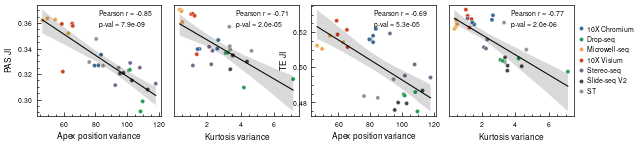

In [179]:
plt.close()
fig, axs = plt.subplots(1,4, figsize=(165*mm, 40*mm))

# 1
sns.scatterplot(
    data = raw_data_feature_df,
    x="apex_position_var",
    y="pas_ji",
    hue="protocol",
    ax=axs[0],
    legend=False,
    palette=palette,
    hue_order=protocol_order
)
sns.regplot(
    data = raw_data_feature_df,
    x="apex_position_var",
    y="pas_ji",
    scatter=False,
    ax=axs[0],
    color="black",
)
slope, intercept, r_value, p_value, std_err = stats.linregress(raw_data_feature_df["apex_position_var"], raw_data_feature_df["pas_ji"])
r2 = r_value**2
pearsonr, pval = stats.pearsonr(raw_data_feature_df["apex_position_var"], raw_data_feature_df["pas_ji"])
axs[0].annotate(f"Pearson r = {pearsonr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
axs[0].annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_xlabel("Apex position variance")
axs[0].set_ylabel("PAS JI")

#2
sns.scatterplot(
    data = raw_data_feature_df,
    x="kurtosis_var",
    y="pas_ji",
    hue="protocol",
    ax=axs[1],
    legend=False,
    palette=palette,
    hue_order=protocol_order
)
sns.regplot(
    data = raw_data_feature_df,
    x="kurtosis_var",
    y="pas_ji",
    scatter=False,
    ax=axs[1],
    color="black",
)
slope, intercept, r_value, p_value, std_err = stats.linregress(raw_data_feature_df["kurtosis_var"], raw_data_feature_df["pas_ji"])
r2 = r_value**2
pearsonr, pval = stats.pearsonr(raw_data_feature_df["kurtosis_var"], raw_data_feature_df["pas_ji"])
axs[1].annotate(f"Pearson r = {pearsonr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
axs[1].annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_xlabel("Kurtosis variance")
axs[1].set_yticks([])
axs[1].set_ylabel("")
axs[1].set_yticklabels([])

#3
sns.scatterplot(
    data = raw_data_feature_df,
    x="apex_position_var",
    y="tmap_te_ji",
    hue="protocol",
    ax=axs[2],
    legend=False,
    palette=palette,
    hue_order=protocol_order
)
sns.regplot(
    data = raw_data_feature_df,
    x="apex_position_var",
    y="tmap_te_ji",
    scatter=False,
    ax=axs[2],
    color="black",
    
)
slope, intercept, r_value, p_value, std_err = stats.linregress(raw_data_feature_df["apex_position_var"], raw_data_feature_df["tmap_te_ji"])
r2 = r_value**2
pearsonr, pval = stats.pearsonr(raw_data_feature_df["apex_position_var"], raw_data_feature_df["tmap_te_ji"])
axs[2].annotate(f"Pearson r = {pearsonr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
axs[2].annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].set_xlabel("Apex position variance")
axs[2].set_ylabel("TE JI")
axs[2].set_yticks([0.48,0.5,0.52])

#4
sns.scatterplot(
    data = raw_data_feature_df,
    x="kurtosis_var",
    y="tmap_te_ji",
    hue="protocol",
    ax=axs[3],
    palette=palette,
    hue_order=protocol_order
)
sns.regplot(
    data = raw_data_feature_df,
    x="kurtosis_var",
    y="tmap_te_ji",
    scatter=False,
    ax=axs[3],
    color="black"
)
# slope, intercept, r_value, p_value, std_err = stats.linregress(raw_data_feature_df["kurtosis_var"], raw_data_feature_df["tmap_te_ji"])
# r2 = r_value**2
pearsonr, pval = stats.pearsonr(raw_data_feature_df["kurtosis_var"], raw_data_feature_df["tmap_te_ji"])
axs[3].annotate(f"Pearson r = {pearsonr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
axs[3].annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[3].set_xlabel("Kurtosis variance")
axs[3].set_yticks([])
axs[3].set_ylabel("")
axs[3].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig("/root/apabenchmark/plot/fig2/consistency_variance.pdf")


In [136]:
plt.subplots_adjust(wspace=0.1)

/tmp/ipykernel_1183/956948974.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1183/956948974.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


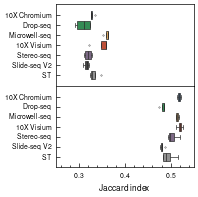

In [174]:
plt.close()
fig, axs = plt.subplots(2,1, figsize=(55*mm, 53*mm))
xmin = 0.25
xmax = 0.55
sns.boxplot(
    data=raw_data_feature_df[["protocol", "pas_ji"]],
    x="pas_ji",
    y="protocol",
    fliersize=0.3,
    linewidth=0.5,
    palette=palette,
    ax=axs[0]
)
axs[0].tick_params(which="minor", left=False)
axs[0].margins(y=0.1)
axs[0].set_xlim(xmin, xmax)
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_ylabel("")
sns.boxplot(
    data=raw_data_feature_df[["protocol", "tmap_te_ji"]],
    x="tmap_te_ji",
    y="protocol",
    fliersize=0.3,
    linewidth=0.5,
    palette=palette,
    ax=axs[1]
)
axs[1].tick_params(which="minor", left=False)
axs[1].margins(y=0.1)
axs[1].set_xlim(xmin, xmax)
axs[1].set_xlabel("Jaccard index")
axs[1].set_ylabel("")
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()
plt.savefig("/root/apabenchmark/plot/fig2/consistency_boxplot.pdf")

/tmp/ipykernel_1183/2696652816.py:5: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(


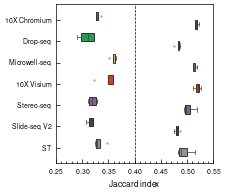

In [227]:
plt.close()
fig, ax = plt.subplots(1,1, figsize=(60*mm, 52*mm))
xmin = 0.25
xmax = 0.55
sns.boxplot(
    data=raw_data_feature_df[["protocol", "pas_ji", "tmap_te_ji"]].melt(id_vars=["protocol"]),
    x="value",
    y="protocol",
    hue="variable",
    fliersize=0.3,
    linewidth=0.5,
    palette=palette,
    ax=ax,
    legend=False
)

for j, bar in enumerate(ax.patches):
    hatch_index = j // (len(ax.patches) // 2)
    bar.set_facecolor(palette[j % (len(ax.patches) // 2)])
    bar.set_edgecolor('black')  # 设置描边颜色为黑色
    bar.set_linewidth(0.5)  # 设置描边线宽为1

ax.tick_params(which="minor", left=False)
ax.set_xlim(xmin, xmax)
ax.set_xlabel("Jaccard index")
ax.set_ylabel("")
ax.axvline(0.4, color="black", linestyle="--")
# ax.axvspan(0.4, ax.get_xlim()[1], color="grey", alpha=0.05)
# ax.axvspan(ax.get_xlim()[0], 0.4, color="#d34123", alpha=0.05)
ax.margins(y=0.05)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.savefig("/root/apabenchmark/plot/fig5/consistency_boxplot.pdf")

In [7]:
pas_ji_matrix = pd.DataFrame(index=ji_paired_df["sample1"].drop_duplicates(), columns=ji_paired_df["sample1"].drop_duplicates())
tmap_te_ji_matrix = pd.DataFrame(index=ji_paired_df["sample1"].drop_duplicates(), columns=ji_paired_df["sample1"].drop_duplicates())
pmap_te_ji_matrix = pd.DataFrame(index=ji_paired_df["sample1"].drop_duplicates(), columns=ji_paired_df["sample1"].drop_duplicates())
for _, row in ji_paired_df.iterrows():
    pas_ji_matrix.loc[row["sample1"], row["sample2"]] = row["pas_ji"]
    pas_ji_matrix.loc[row["sample2"], row["sample1"]] = row["pas_ji"]
    tmap_te_ji_matrix.loc[row["sample1"], row["sample2"]] = row["tmap_te_ji"]
    tmap_te_ji_matrix.loc[row["sample2"], row["sample1"]] = row["tmap_te_ji"]
    pmap_te_ji_matrix.loc[row["sample1"], row["sample2"]] = row["pmap_te_ji"]
    pmap_te_ji_matrix.loc[row["sample2"], row["sample1"]] = row["pmap_te_ji"]

# matrix = matrix.fillna(0)
pas_ji_matrix = pas_ji_matrix.astype(float)
tmap_te_ji_matrix = tmap_te_ji_matrix.astype(float)
pmap_te_ji_matrix = pmap_te_ji_matrix.astype(float)

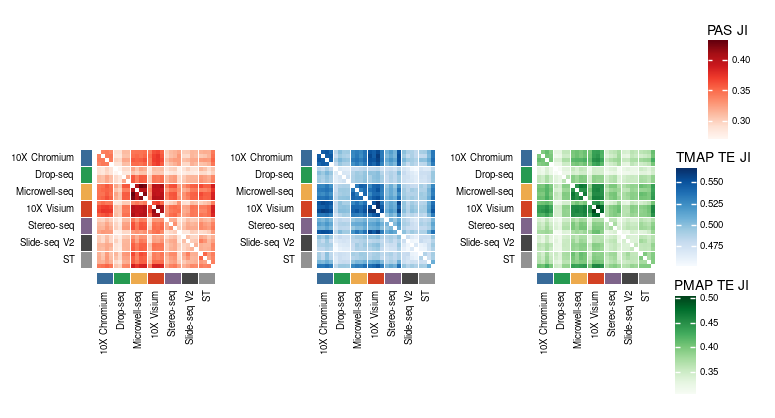

In [44]:
plt.close()
protocol_cap = [protocol_map[x.split("_")[0]] for x in pas_ji_matrix.columns]
label = ["PAS JI", "TMAP TE JI", "PMAP TE JI"]
cmap = ["Reds", "Blues", "Greens"]

c = 0
for i, matrix in enumerate([pas_ji_matrix, tmap_te_ji_matrix, pmap_te_ji_matrix]):
    h = ma.Heatmap(
        matrix,
        cmap=cmap[i],
        label=label[i],
        width=30*mm,
        height=30*mm,
    )
    
    h.group_cols(group=protocol_cap, order=protocol_order)
    h.group_rows(group=protocol_cap, order=protocol_order)

    h.add_left(mp.Chunk(["" for i in range(7)], palette, ),pad=0.05)
    h.add_left(mp.Chunk(protocol_order, rotation=0))
    h.add_bottom(mp.Chunk(["" for i in range(7)], palette),pad=0.05)
    h.add_bottom(mp.Chunk(protocol_order, rotation=90))
    
    h.add_legends("right", align_legends="top",pad=0.3*mm)

    if c == 0:
        c = h
    else:
        c = c + 0.1 + h
c.add_legends("right", align_legends="top",pad=0.3*mm)
c.render()

In [45]:
plt.savefig("/root/apabenchmark/plot/fig6/sample_ji_heatmap.pdf", bbox_inches="tight")

/tmp/ipykernel_1651956/4073114645.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pas_ci_plot_df = ci_df.groupby(["tool", "protocol"])[["pas_ci"]].mean().reset_index().pivot("tool", "protocol", "pas_ci")


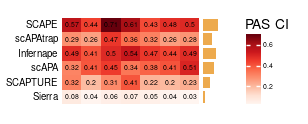

In [9]:
plt.close()
cmap="Reds"
pas_ci_plot_df = ci_df.groupby(["tool", "protocol"])[["pas_ci"]].mean().reset_index().pivot("tool", "protocol", "pas_ci")
h1 = ma.Heatmap(
    pas_ci_plot_df,
    cmap=cmap,
    label="PAS CI",
    width=35*mm,
    height=22*mm,
)
h1.add_layer(ma.plotter.TextMesh(np.around(pas_ci_plot_df.to_numpy(),2), color="black", fontsize=5))
h1_tool = mp.Labels(ci_df["tool"].unique())
overall_ci = mp.Numbers(
    ci_by_tool_df.groupby("tool")[["pas_ci"]].mean().values.reshape(-1),
    color="#edaa4d", 
    label="Overall PAS CI",
    show_value=False,
    )
h1.add_legends("right", align_stacks="center", align_legends="top", pad=0.3*mm)
h1.add_left(h1_tool, pad=0.3*mm)
h1.add_right(overall_ci, pad=1*mm, size=7*mm, name="overall_ci")

h1.render()
h1.get_ax("overall_ci").xaxis.set_visible(False)
h1.get_ax("overall_ci").set_xlabel("")
h1.get_ax("overall_ci").spines['bottom'].set_visible(False)
h1.get_ax("overall_ci").tick_params(which="both", left=False, right=False, direction="out")
h1.get_ax("overall_ci").set_xticks([0,1])
h1.get_ax("overall_ci").set_xlim(0, 1)

plt.savefig("/root/apabenchmark/plot/fig3/pas_ci_heatmap.pdf", bbox_inches="tight", dpi=300)

/tmp/ipykernel_1651956/2369949571.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  te_ci_plot_df = ci_df.groupby(["tool", "protocol"])[["tmap_te_ci"]].mean().reset_index().pivot("tool", "protocol", "tmap_te_ci")


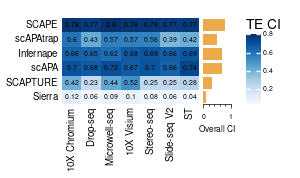

: 

In [14]:
cmap="Blues"
te_ci_plot_df = ci_df.groupby(["tool", "protocol"])[["tmap_te_ci"]].mean().reset_index().pivot("tool", "protocol", "tmap_te_ci")
h2 = ma.Heatmap(
    te_ci_plot_df,
    cmap=cmap,
    label="TE CI",
    width=35*mm,
    height=22*mm,
)
h2.add_layer(ma.plotter.TextMesh(np.around(te_ci_plot_df.to_numpy(),2), fontsize=5))
overall_ci = mp.Numbers(
    ci_by_tool_df.groupby("tool")[["tmap_te_ci"]].mean().values.reshape(-1),
    color="#edaa4d", 
    label="Overall CI",
    show_value=False,
    )
h2_tool = mp.Labels(ci_df["tool"].unique())
h2_protocol = mp.Labels(ci_df["protocol"].unique())
# h2.add_legends("right", align_stacks="center", align_legends="top", pad=1*mm)
h2.add_legends("right", align_stacks="center", align_legends="top", pad=0.3*mm)
h2.add_left(h2_tool, pad=0.3*mm)
h2.add_bottom(h2_protocol, pad=0.3*mm)
h2.add_right(overall_ci, pad=1*mm, size=7*mm, name="overall_ci")
h2.render()
h2.get_ax("overall_ci").tick_params(which="both", left=False, right=False, direction="out")
h2.get_ax("overall_ci").set_xticks([0,1])
h2.get_ax("overall_ci").set_xlim(0, 1)
plt.savefig("/root/apabenchmark/plot/fig3/te_ci_heatmap.pdf", bbox_inches="tight", dpi=300)